## Import Libraries

In [1]:
#!pip install ttpy
#!pip install git+https://github.com/oseledets/ttpy.git@refs/pull/87/head
# As soon as #87 is merged you can drop @... suffix and run.
!pip install git+https://github.com/oseledets/ttpy.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/oseledets/ttpy.git to /tmp/pip-req-build-4p0lg825
  Running command git clone --filter=blob:none --quiet https://github.com/oseledets/ttpy.git /tmp/pip-req-build-4p0lg825
  Resolved https://github.com/oseledets/ttpy.git to commit a50d5e0ce2a033a4b1aa703715cb85d715b9b34a
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for ttpy: filename=ttpy-1.2.0-cp310-cp310-linux_x86_64.whl size=3546010 sha256=2a8831d3a19a40e9b44261694078fb30a2fafbc05d634c1324849a73fa693299
  Stored in directory: /tmp/pip-ephem-wheel-cache-46m7yv1l/wheels/0f/9c/16/16342a640cb36d2dad60b14dea6a8e40d25a21802581aee13c
Successfully built ttpy


In [2]:
from __future__ import print_function, absolute_import, division
import sys
sys.path.append('../')

import numpy as np
from numpy import linalg as LA
from scipy.integrate import solve_ivp

import math, tt
import tt.ksl
import time

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import matplotlib.pyplot as plt
import networkx as nx
import scipy.special as sp

# Code to support deprecated numpy commands in TT-Toolbox
np.object=object
np.int=int
np.complex=complex
np.float=float
np.bool=bool
time.clock=time.perf_counter

## **Hands-On Tutorial on Tensor Trains**

The goal of this tutorial is to get a quick start into the [TT-Toolbox](https://github.com/oseledets/ttpy) for fast multilinear algebra computations. Here, we introduce the basic routines for multidimensional array operations in TT-format with examples, incluiding a presentation based on the quick start document developed by Ivan Oseledets, Sergey Dolgov, Vladimir Kazeev, Olga Lebedeva, Thomas Mach, and developments at Yale by the Batista group.



### **What is a tensor train?**

The TT-format of a tensor **A** is defined, as follows:

$A(l_1, l_2, \dots, l_d) = \sum_{\alpha_1=1}^{r_1} \cdots \sum_{\alpha_{d-1}=1}^{r_{d-1}} G_1(l_1,\alpha_1) G_2(\alpha_1,l_2,\alpha_2) \cdots G_d(\alpha_{d-1},l_d),$

or more concisely $A(l_1, l_2, \dots, l_d)
= G_1(l_1) \times G_2(l_2) \times \cdots \times G_d(l_d),$ where $G_k(l_k)$ are $r_{k-1} \times r_k$ matrices, and $r_0 = r_d = 1$, as represented in the following diagram:

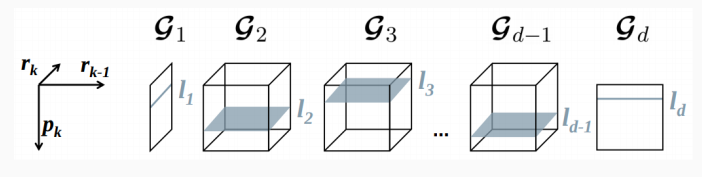

The approximation in this format is known to be stable and can be obtained by iterative [QR](https://en.wikipedia.org/wiki/QR_decomposition) or [SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition) decompositions. Matrices can also be represented in TT-format, analogously, so matrix-by-vector products can be performed by multiplication of tensor trains.

A vector of length $n_1 \dots n_d$ is said to be in the TT-format, if it has low TT-ranks considered as $d$-dimensional array (in MATLAB it is just a single call to the `reshape' function. Matrices acting on such vectors have size $M \times N$, where $N =\prod_{k=1}^d n_k$.

For simplicity, assume they are square so each element of such matrix can be indexed by $i_1, \dots, i_d, j_1,\dots j_d$, where multiindex $i_k$, $k = 1, \dots, d$ corresponds to
rows, and $j_k$, $k = 1, \dots, d$ --to columns of the matrix. The matrix $M$ is said to be in the TT-format if

$M(i_1, \dots,i_d, j_1 \dots, j_d) = M_1(i_1, j_1) M_2(i_2, j_2) \dots M_d(i_d, j_d),$

and $M_k(i_k,j_k)$ is an $r_{k-1} \times r_k$ matrix.

Therefore, the TT-Toolbox has two main classes: **tt_tensor** and **tt_matrix**, where tt_tensor is a TT-representation of a d-dimensional array (i.e., a tensor product of vectors), and tt_matrix is the TT-representation of a d-level matrix (i.e., a tensor product of matrices).

The class tt_tensor contains the following attributes:

1. tt.core:  cores of the TT-decomposition stored in one “long” 1D array (i.e., core: is an ndarray flatten (Fortran-ordered) that stores the TT cores sequentially. To get a list of three-dimensional cores use "tt.vector.to_list(my_tensor)")

2. tt.d:  dimensionality of the tensor
3. tt.n:  mode sizes of the tensor
4. tt.r:  ranks of the TT decomposition of the tensor
5. tt.ps:  markers for position of the k-the core in array tt.core: if ps=tt.ps, then k-core can be obtained as follows:


### **Basic Routines**


#### **tt_tensor class**

**1. tt.tensor(y,eps)**: constructs TT-tensor from full array y with accuracy eps

In [3]:
y = np.array([[1,2], [3,4]])
tty=tt.tensor(y,eps=1e-14); print("tty=",tty)

tty= This is a 2-dimensional tensor 
r(0)=1, n(0)=2 
r(1)=2, n(1)=2 
r(2)=1 



**Attributes of tensor train tty:**

**2. tty.n**: returns the array of mode dimensions of tty

In [4]:
array_mode_dimensions=tty.n; print("mode dimensions of tty =",array_mode_dimensions)

mode dimensions of tty = [2 2]


**3. tty.r**: returns the array of core ranks

In [5]:
array_core_ranks=tty.r; print("core ranks of tty =",array_core_ranks)

core ranks of tty = [1 2 1]


**4. tty.erank**: returns effective rank of the TT-tensor

In [6]:
print("effective rank of tty", tty.erank)

effective rank of tty 2.0


**5. tty.d**: returns the dimensionality (number of cores) of tty

In [7]:
dimensionality=tty.d; print("dimensionality of tty=",dimensionality)

dimensionality of tty= 2


**6. tty.core**:  returns the array of cores

In [8]:
print("1d flatten cores of tty =", tty.core)

1d flatten cores of tty = [-2.21087956 -4.99780755 -0.33468131  0.14805293 -0.57604844  0.81741556
 -0.81741556 -0.57604844]


**7. r=tty.r[k]**: returns the k-th rank of the TT-decomposition, and all ranks if k is not specified

In [9]:
print("rank 1 of tty =", tty.r[1])
print("all ranks of tty =", tty.r)

rank 1 of tty = 2
all ranks of tty = [1 2 1]


**8. tty.ps** returns the indices of each core

In [10]:
print("indices_of_cores of tty=",tty.ps);

indices_of_cores of tty= [1 5 9]


**9. tty.core[ps[k]:ps[k+1]-1]**: returns the entry values of core k corresponding to the indices of the k-th core

In [11]:
k=1; ps=tty.ps; print("k-th_core=", tty.core[ps[k]:ps[k+1]-1]);

k-th_core= [ 0.81741556 -0.81741556 -0.57604844]


**10. tty.full()** converts TT-tensor tty to a full array

In [12]:
y=tty.full(); print("y=",y)

y= [[1. 2.]
 [3. 4.]]


**11. tty.round(eps)**  approximates the TT-tensor tty by another TT-tensor ttny with smaller ranks

In [13]:
ttny=tty.round(1e-2); print("ttny=",ttny)

ttny= This is a 2-dimensional tensor 
r(0)=1, n(0)=2 
r(1)=2, n(1)=2 
r(2)=1 



**12. tt.rand(n,d,r)**: builds a d-dimensional TT of random numbers (from a Normal distribution), with dimension d, ranks r, and mode sizes n, where n and r can be arrays of integers defining n and r for each mode, or single integers (then all dimensions and ranks are the same).

---



In [14]:
tty=tt.rand(5,2,3); print("tty=",tty)

tty= This is a 2-dimensional tensor 
r(0)=1, n(0)=5 
r(1)=3, n(1)=5 
r(2)=1 



**13. tt=tt.ones(n,d)** generates a tt of ones with mode sizes n, dimension d of all ones

In [15]:
n=2; d=3;ttones=tt.ones(n,d); print("ttones=",ttones)

ttones= This is a 3-dimensional tensor 
r(0)=1, n(0)=2 
r(1)=1, n(1)=2 
r(2)=1, n(2)=2 
r(3)=1 



**14. tty.norm()**: returns Frobenius norm of the TT-tensor.

In [16]:
print("norm of tty=",tty.norm())

norm of tty= 6.951268486857991


**15. elem=tty[i1,i2,...,id]**:  computes element of the TT-tensor in position i1,i2,...,id.

In [17]:
print("tensor element tty[1,1]=",tty[1,1])

tensor element tty[1,1]= -0.1316787844219594


**16. elem=tty[ind]**: where ind is an integer array of length d return element of the TT-tensor in the position specified by multiindex ind.


In [18]:
ind=np.array([1,1]); print("tensor element tty[1,1]=",tty[ind])

tensor element tty[1,1]= -0.1316787844219594


**17. tty.diag(tty)**: constructs a diagonal TT-matrix from TT-tensor, or takes diagonal of a TT-matrix.

In [19]:
ttm=tt.diag(tty); print("ttm=",ttm)

ttm= This is a 2-dimensional matrix 
r(0)=1, n(0)=5, m(0)=5 
r(1)=3, n(1)=5, m(1)=5 
r(2)=1 



**18. tt.kron(tt1,tt2)**: compute the outer product of tt1 and tt2, thus generating a train where the number of dimensions equals the sum of the number of dimensions of the two input tensors trains. For TT-matrices it computes their Kronecker product in TT-format.

In [20]:
y1 = np.array([1,2]); tty1 = tt.tensor(y1);
y2 = np.array([3,4]); tty2 = tt.tensor(y2);
tty= tt.kron(tty1,tty2)

**19. Binary operations** tt1 . tt2, where '.' can be '+', '-' or '*'

In [21]:
tts=ttny+tty; print("tts=",tts)
ttp=ttny*tty; print("ttp=",ttp)
# tt12=tty1*tty2; print("ttp=",tt12) # bug for tensors with one core

tts= This is a 2-dimensional tensor 
r(0)=1, n(0)=2 
r(1)=3, n(1)=2 
r(2)=1 

ttp= This is a 2-dimensional tensor 
r(0)=1, n(0)=2 
r(1)=2, n(1)=2 
r(2)=1 



**20. tt.dot(tt1,tt2)**: returns the dot (scalar) product of tensor trains tt1 and tt2

In [22]:
tt1=tty; tt2=tty; print("dot product=", tt.dot(tt1,tt2))

dot product= 125.0


#### **tt_matrix class**

**21. tt.matrix(y,eps)** constructs TT-matrix from full array

In [ ]:
y = np.array([[1,2], [4,5], [4,5]]); ttmy=tt.matrix(y,eps=1e-14);  print("ttmy=",ttmy); ttmy=tt.kron(ttmy,ttmy); print("ttmy=",ttmy)

ttmy= This is a 1-dimensional matrix 
r(0)=1, n(0)=3, m(0)=2 
r(1)=1 

ttmy= This is a 2-dimensional matrix 
r(0)=1, n(0)=3, m(0)=2 
r(1)=1, n(1)=3, m(1)=2 
r(2)=1 



**22. ttmy.full()**  converts TT-matrix ttmy to a full square matrix

In [ ]:
y=ttmy.full(); print("y=",y)

y= [[ 1.  2.  2.  4.]
 [ 4.  5.  8. 10.]
 [ 4.  5.  8. 10.]
 [ 4.  8.  5. 10.]
 [16. 20. 20. 25.]
 [16. 20. 20. 25.]
 [ 4.  8.  5. 10.]
 [16. 20. 20. 25.]
 [16. 20. 20. 25.]]


**23. ttmy.n** returns array of n mode dimensions of (nxm) ttmy (i.e., # of rows)

In [ ]:
print("n modes of ttmy", ttmy.n)

n modes of ttmy [3 3]


**24. ttmy.m** returns array of m mode dimensions of (nxm) ttmy (i.e., # of columns)

In [ ]:
print("m modes of ttmy", ttmy.m)

m modes of ttmy [2 2]


**25. ttmy.tt.r** returns array of ranks of ttmy

In [ ]:
print("ranks of ttmy", ttmy.tt.r)

ranks of ttmy [1 1 1]


**26. ttmy.tt.d** returns dimensionality of ttmy (# of cores)

In [ ]:
print("dimensionality of ttmy", ttmy.tt.d)


dimensionality of ttmy 2


**27. ttmy.tt.ps** returns the indices of cores of ttmy

In [ ]:
print("indices of cores of ttmy", ttmy.tt.ps)

indices of cores of ttmy [ 1  7 13]


**28. ttmy.tt.core** returns the array of cores of ttmy

In [ ]:
print("cores of ttmy", ttmy.tt.core)

cores of ttmy [1. 4. 4. 2. 5. 5. 1. 4. 4. 2. 5. 5.]


**29. matvec(A,b)** returns matrix-by-vector multiplication where A is a tt_matrix and b is a tt_tensor of appropriate sizes

In [ ]:
A=ttmy;b=tty; print("A*b=",tt.matvec(A,b))

A*b= This is a 2-dimensional tensor 
r(0)=1, n(0)=3 
r(1)=1, n(1)=3 
r(2)=1 



**30. A * B** returns matrix-by-matrix product where A and B have tt_matrix format

In [ ]:
B=A; print("A*B=",A*B)

A*B= This is a 2-dimensional matrix 
r(0)=1, n(0)=3, m(0)=2 
r(1)=1, n(1)=3, m(1)=2 
r(2)=1 



**31. tt=tt.eye(n,d)** generates a tt of ones with mode sizes n, dimension d of all ones

In [ ]:
# n=2; d=3;tteye=tt.eye(n,d); print("tteye=",tteye) # Deprecated

**32. tt.qlaplace_dd(d)** generates a tensor train of the Laplacian operator with Dirichlet boundary conditions on a gred with $2^{d_1} \times 2^{d_1} \times \dots 2^{d_n}$

In [ ]:
# Example
d1=2;d2=2;d3=2; d=np.array([d1,d2,d3]);lp = tt.qlaplace_dd(d);lp

This is a 6-dimensional matrix 
r(0)=1, n(0)=2, m(0)=2 
r(1)=4, n(1)=2, m(1)=2 
r(2)=2, n(2)=2, m(2)=2 
r(3)=4, n(3)=2, m(3)=2 
r(4)=2, n(4)=2, m(4)=2 
r(5)=3, n(5)=2, m(5)=2 
r(6)=3 

**33. tt.linspace(n, d, a, b)** creates a QTT-representation of a uniform grid on an interval [a, b]

In [ ]:
n=2;d=21;a=0;b=1; sol=tt.linspace(n, d, a, b);sol

This is a 21-dimensional tensor 
r(0)=1, n(0)=2 
r(1)=2, n(1)=2 
r(2)=2, n(2)=2 
r(3)=2, n(3)=2 
r(4)=2, n(4)=2 
r(5)=2, n(5)=2 
r(6)=2, n(6)=2 
r(7)=2, n(7)=2 
r(8)=2, n(8)=2 
r(9)=2, n(9)=2 
r(10)=2, n(10)=2 
r(11)=2, n(11)=2 
r(12)=2, n(12)=2 
r(13)=2, n(13)=2 
r(14)=2, n(14)=2 
r(15)=2, n(15)=2 
r(16)=2, n(16)=2 
r(17)=2, n(17)=2 
r(18)=2, n(18)=2 
r(19)=2, n(19)=2 
r(20)=2, n(20)=2 
r(21)=1 

**34. tt.reshape(tty,s)** reshapes tty to shape specified by array s

In [23]:
# Example
print("sol=",sol);d=int(sol.d/3)
sol_3d=tt.reshape(sol, [2**d,2**d,2**d])
sol_3d

NameError: ignored

**35. tmatvec(U,f)** returns matrix-by-vector multiplication where f is a tt_tensor and U is a matrix tt_tensor operator (with twice the number of cores of f).


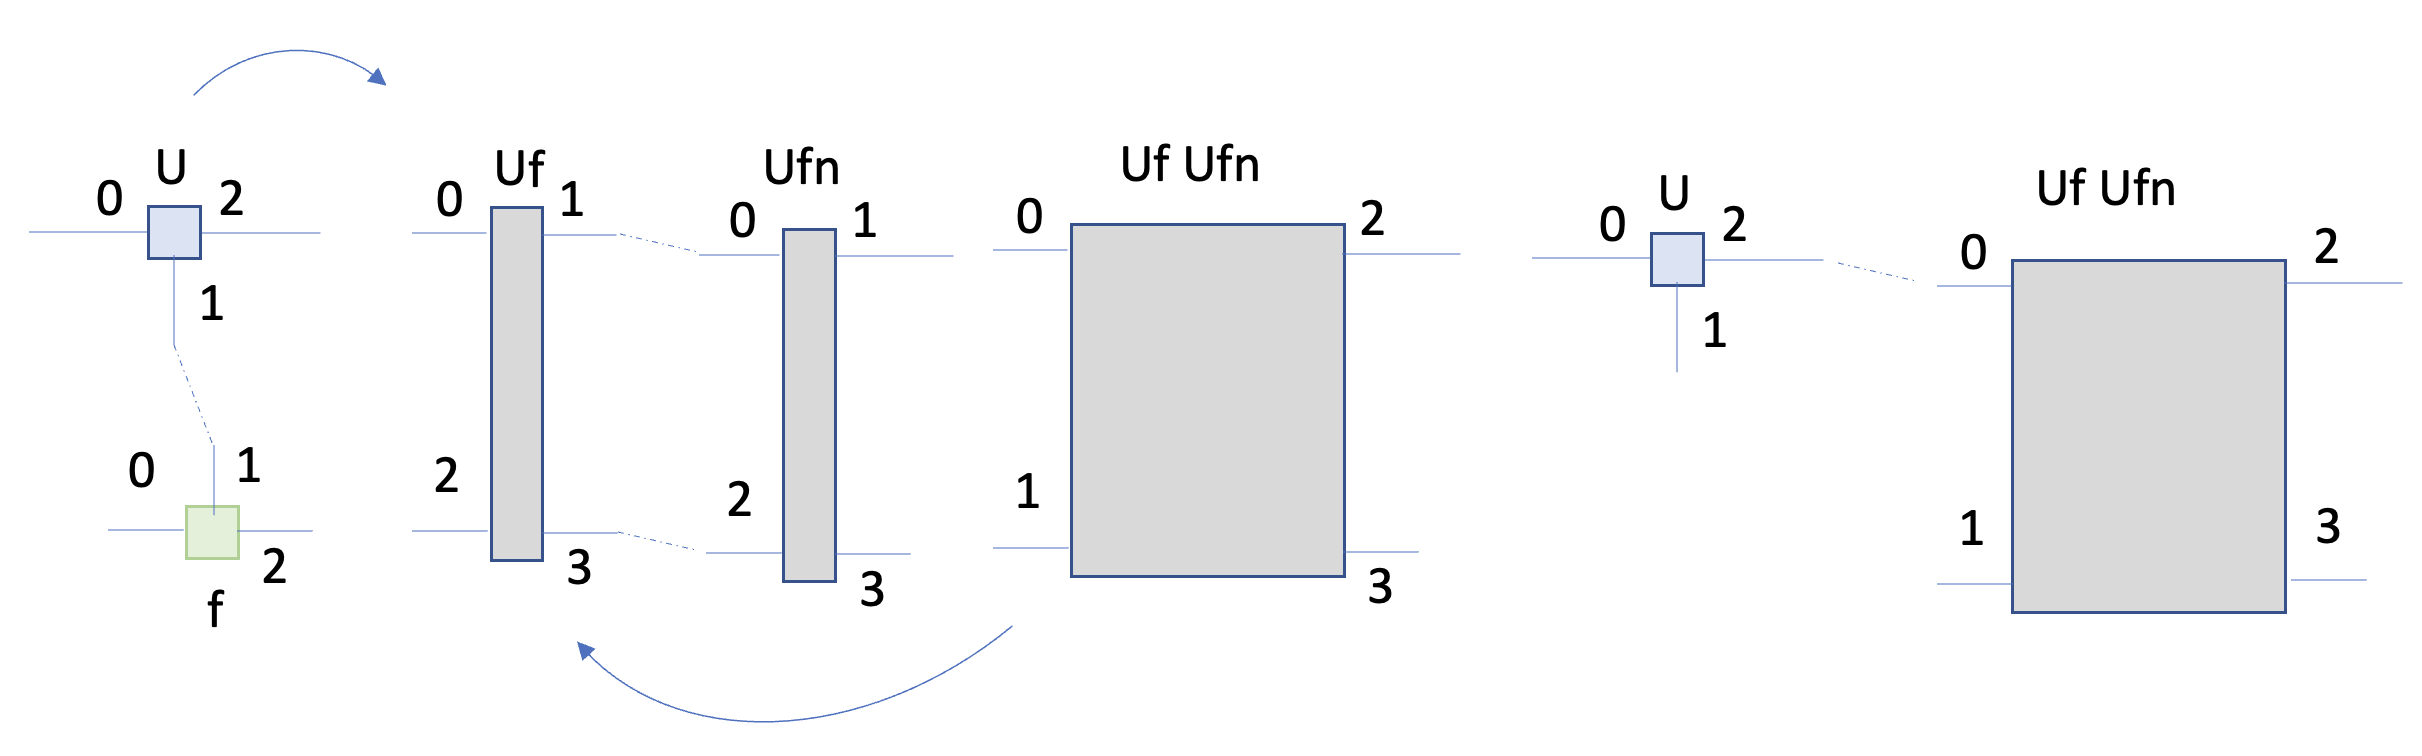

TTT(X,Y) computes the outer product of two multi-dimensional arrays X and Y. (equivalent to tt.kron?)

TTT(X,Y,XDIMS,YDIMS) computes the contracted product of X and Y in the modes specified by the row vectors XDIMS and YDIMS.

TTT(X,Y,DIMS) is equivalent to calling TTT(X,Y,DIMS,DIMS).

In the case of complex tensors, the complex conjugate of X is used.


**Examples**

x = rand(4,2,3); y = rand(3,4,2);

z = ttt(x,y)                  #<-- outer product of x and y

z = ttt(x,x,1:3)              #<-- inner product of x with itself

z = ttt(x,y,[1 2 3],[2 3 1])  #<-- inner product of x with permuted y

z = ttt(x,y,[1 3],[2 1])      #<-- outer product along specified dims

x = rand(4,2,3); y = rand(3,4,2);

z = ttt(x,y)                  %<-- outer product of x and y

z = ttt(x,x,1:3)              %<-- inner product of x with itself

z = ttt(x,y,[1 2 3],[2 3 1])  %<-- inner product of x with permuted y

z = ttt(x,y,[1 3],[2 1])      %<-- outer product along specified dims

In [ ]:
def tmatvec(ttu,ttf):
    # Matrix-by-vector multiplication, both ttu matrix and ttf vector in tt format
    U=ttu.to_list(ttu)                                 # get cores from ttU
    f=ttf.to_list(ttf)                                 # get cores from ttf
    d=len(f);j=1
    Uf=np.tensordot(U[d],f[0],axes=([1],[1]))
    if d > 1:
        for k in range(1,d):
            Ufn=np.tensordot(U[d+k],f[k],axes=([1],[1]))
            Uf=np.tensordot(Uf,Ufn,axes=([j,3],[0,2]));j=2
    f[d-1]=np.tensordot(U[d-1],Uf,axes=([2],[0]))
    f[d-1]=f[d-1].reshape(f[d-1].shape[0],f[d-1].shape[1],f[d-1].shape[2]*f[d-1].shape[3]*f[d-1].shape[4])
    f[:d-1]=U[:d-1]
    out=ttf.from_list(f)                      # assemble tt from updated cores
    return out

Simple example for testing tmatvec

In [ ]:
n=3
f = np.arange(2**n).reshape([2]*n)
ttf=tt.tensor(f,eps=1e-14);

ttu = tt.tensor(np.kron(f,f).reshape([2]*2*n));

fn=tmatvec(ttu,ttf)
fn=tmatvec(ttu,fn)

print(fn.full())
print(ttu.r,fn.r) # Note that the ranks of fn are fixed by the ranks of ttu

[[[  5464.  20184.]
  [ 15448.  57048.]]

 [[ 34904.  49624.]
  [ 98648. 140248.]]]
[1 2 4 4 4 2 1] [1 2 4 1]


Comparison to the tt-matrix format

In [ ]:
u=np.kron(f,f).reshape([2]*2*n)
ttu=tt.matrix(u)

fn=tt.matvec(ttu,ttf)
fn=tt.matvec(ttu,fn)

print(fn.full())
#fn=fn.round(eps=1e-14)
print(ttu.r,fn.r)  # Note that the ranks of fn keep growing

[[[  5464.  20184.]
  [ 15448.  57048.]]

 [[ 34904.  49624.]
  [ 98648. 140248.]]]
[1 4 4 1] [ 1 32 32  1]


Vector-by-vector multiplication

In [ ]:
def prod(ttf1,ttf2):
    # vector-by-vector multiplication both in tt format

    ttf=ttf1*ttf2
    f=ttf.to_list(ttf)                        # get cores from ttf
    d=len(f);j=1

    # Identity Matrix
    vm = np.eye(2**d)                         # Identity matrix
    vm = vm.reshape([2]*d*2)                  # Quantics format
    vm = tt.tensor(vm)                        # TT-vector format
    U=vm.to_list(vm)                          # get cores from vm

    # Projection with Identity Matrix
    Uf=np.tensordot(U[d],f[0],axes=([1],[1]))
    if d > 1:
        for k in range(1,d):
            Ufn=np.tensordot(U[d+k],f[k],axes=([1],[1]))
            Uf=np.tensordot(Uf,Ufn,axes=([j,3],[0,2]));j=2
    f[d-1]=np.tensordot(U[d-1],Uf,axes=([2],[0]))
    f[d-1]=f[d-1].reshape(f[d-1].shape[0],f[d-1].shape[1],f[d-1].shape[2]*f[d-1].shape[3]*f[d-1].shape[4])
    f[:d-1]=U[:d-1]
    out=ttf.from_list(f)                      # assemble tt from updated cores
    return out

In [ ]:
def sums(ttf1,ttf2):
    # vector-vector summation both in tt format

    ttf=ttf1+ttf2
    f=ttf.to_list(ttf)                        # get cores from ttf
    d=len(f);j=1

    # Identity Matrix
    vm = np.eye(2**d)                         # Identity matrix
    vm = vm.reshape([2]*d*2)                  # Quantics format
    vm = tt.tensor(vm)                        # TT-vector format
    U=vm.to_list(vm)                          # get cores from vm
    #vm=vm.round(eps=1e-14)
    #print(vm.r)

    # Projection with Identity Matrix
    Uf=np.tensordot(U[d],f[0],axes=([1],[1]))
    if d > 1:
        for k in range(1,d):
            Ufn=np.tensordot(U[d+k],f[k],axes=([1],[1]))
            Uf=np.tensordot(Uf,Ufn,axes=([j,3],[0,2]));j=2
    f[d-1]=np.tensordot(U[d-1],Uf,axes=([2],[0]))
    f[d-1]=f[d-1].reshape(f[d-1].shape[0],f[d-1].shape[1],f[d-1].shape[2]*f[d-1].shape[3]*f[d-1].shape[4])
    f[:d-1]=U[:d-1]

    out=ttf.from_list(f)                      # assemble tt from updated cores

    return out

In [ ]:
print("Input vector")
v = np.arange(2**n)
v = v.reshape([2]*n)
v = tt.tensor(v)
print(v.full().flatten())

# Multiplication
v2=prod(v,v)
v2=prod(v2,v)
print("Multiplication: v^3")
print(v2.r,v2.full().flatten())  # Note that the ranks of v2 are fixed by the ranks of vm
v22=v*v*v
#v22=v22.round(eps=1e-14)
print(v22.r,v22.full().flatten())   # Note that the ranks of v22 keep growing

# Summation
vs=sums(v,v)
vs=sums(vs,v)
print("Sum: v+v+v")
print(vs.r,vs.full().flatten())  # Note that the ranks of vs are fixed by the ranks of vm
vss=v+v+v
print(vss.r,vss.full().flatten())   # Note that the ranks of vss keep growing

Input vector
[-9.43689571e-16  1.00000000e+00  2.00000000e+00  3.00000000e+00
  4.00000000e+00  5.00000000e+00  6.00000000e+00  7.00000000e+00]
Multiplication: v^3
[1 2 4 1] [2.31111593e-32 1.00000000e+00 8.00000000e+00 2.70000000e+01
 6.40000000e+01 1.25000000e+02 2.16000000e+02 3.43000000e+02]
[1 8 8 1] [3.05311332e-16 1.00000000e+00 8.00000000e+00 2.70000000e+01
 6.40000000e+01 1.25000000e+02 2.16000000e+02 3.43000000e+02]
Sum: v+v+v
[1 2 4 1] [-2.83106871e-15  3.00000000e+00  6.00000000e+00  9.00000000e+00
  1.20000000e+01  1.50000000e+01  1.80000000e+01  2.10000000e+01]
[1 6 6 1] [-2.66453526e-15  3.00000000e+00  6.00000000e+00  9.00000000e+00
  1.20000000e+01  1.50000000e+01  1.80000000e+01  2.10000000e+01]


### **Advanced functions**

#### **1. Linear System Solver**

x = tt.amen.amen_solve2(A, y,y, tol, varargin) solves the following linear system:

\begin{equation}
A*x = y
\end{equation}
with accuracy/residual tol using the AMEn iteration.

Matrix A has to be given in the TT-format, right-hand side y should be given in the TT-format also. Options are provided in form 'PropertyName1',PropertyValue1,'PropertyName2',PropertyValue2 and so on. The parameters are set to default (in brackets in the following)

The list of option names and default values:
*   x0 - initial approximation [random rank-2 tensor]
*   nswp - maximal number of sweeps [50]
*   rmax - maximal TT-rank of the solution [1000]
*   verb - verbosity level, 0-silent, 1-sweep info, 2-block info [1]
*   max_full_size - maximal size of the local matrix for the full solver [50]
*   local_prec - local preconditioner: '' (no prec.), 'ljacobi','cjacobi', 'rjacobi' ['']
*   local_iters - number of local gmres restarts [2]
*   local_restart - dimension of local gmres [40]
*   kickrank - compression rank of the residual Z, i.e. enrichment size [4]
*   kicktype - how to truncate Z: 'svd', 'als' or 'rand' ['als']
*   kickrank2 - size of the secondary random enrichment for Z (kicktype=='als' only) [0]
*   ismex - shall we use the MEX lib solve3d_2 for local solution instead of gmres. It safely switches off automatically if solve3d_2 is not found in the MATLAB path, as well as on complex data. To obtain solve3d_2, you need to compile it in the TT-Toolbox/fmex directory, please follow instructions there [true]
*   resid_damp - solve local problems with accuracy tol/resid_damp. Larger value may reduce a spurious noise from inexact local solutions, but increase CPU time [2]
*   trunc_norm - truncate in either Frob. ('fro'), or residual norm ('residual') ['residual']
*   z0 - initial guess for Z (kicktype=='als' only).
*   tol_exit - stopping difference between consecutive iterations (if trunc_norm=='fro') or residual (trunc_norm=='resid') [tol]
*   symm - shall we symmetrize the problem (A'Ax=A'y) before the solution [false]


In [ ]:
# Example: Use amen_solve to solve the Poisson eqn.
import tt.amen
d =7; A= tt.qlaplace_dd([d,d,d]);
y = tt.ones(2,3*d)
#  linear system solution via AMR scheme
x = tt.amen.amen_solve(A,y,y,1e-6);y

This is a 21-dimensional tensor 
r(0)=1, n(0)=2 
r(1)=1, n(1)=2 
r(2)=1, n(2)=2 
r(3)=1, n(3)=2 
r(4)=1, n(4)=2 
r(5)=1, n(5)=2 
r(6)=1, n(6)=2 
r(7)=1, n(7)=2 
r(8)=1, n(8)=2 
r(9)=1, n(9)=2 
r(10)=1, n(10)=2 
r(11)=1, n(11)=2 
r(12)=1, n(12)=2 
r(13)=1, n(13)=2 
r(14)=1, n(14)=2 
r(15)=1, n(15)=2 
r(16)=1, n(16)=2 
r(17)=1, n(17)=2 
r(18)=1, n(18)=2 
r(19)=1, n(19)=2 
r(20)=1, n(20)=2 
r(21)=1 

#### **2. Eigenvalue Solver**

tt.eigb.eigb(A, y0, eps, rmax=150, nswp=20, max_full_size=1000, verb=1)

Computes the minimal eigenvalues in tensor train format.

This function uses alternating least-squares algorithm for the computation of several minimal eigenvalues. If you want maximal eigenvalues, just send -A to the function

        S. V. Dolgov, B. N. Khoromskij, I. V. Oseledets, and D. V. Savostyanov.
        Computation of extreme eigenvalues in higher dimensions using block tensor train format. Computer Phys. Comm.,185(4):1207-1216, 2014. http://dx.doi.org/10.1016/j.cpc.2013.12.017



*   param A: Matrix in the TT-format
*   type A: matrix
*   param y0: Initial guess in the block TT-format, r(d+1) is the number of eigenvalues sought
*   type y0: tensor
*   param eps: Accuracy required
*   type eps: float
*   param rmax: Maximal rank
*   type rmax: int
*   param kickrank: Addition rank, the larger the more robus the method,
*   type kickrank: int
*   rtype: A tuple (ev, tensor), where ev is a list of eigenvalues, tensor is an approximation to eigenvectors.

In [ ]:
# Example
import tt.eigb
d = 8; f = 3; n=2
r = [8] * (d * f + 1); r[d * f] = 8; r[0] = 1
x = tt.rand(n, d * f, r)
a = tt.qlaplace_dd([8, 8, 8])
sol, ev = tt.eigb.eigb(a, x, 1e-6, verb=1)
print("sol=",sol,"ev=",ev)

sol= This is a 24-dimensional tensor 
r(0)=1, n(0)=2 
r(1)=2, n(1)=2 
r(2)=4, n(2)=2 
r(3)=5, n(3)=2 
r(4)=6, n(4)=2 
r(5)=7, n(5)=2 
r(6)=7, n(6)=2 
r(7)=7, n(7)=2 
r(8)=4, n(8)=2 
r(9)=7, n(9)=2 
r(10)=11, n(10)=2 
r(11)=11, n(11)=2 
r(12)=11, n(12)=2 
r(13)=11, n(13)=2 
r(14)=11, n(14)=2 
r(15)=11, n(15)=2 
r(16)=6, n(16)=2 
r(17)=11, n(17)=2 
r(18)=16, n(18)=2 
r(19)=17, n(19)=2 
r(20)=17, n(20)=2 
r(21)=17, n(21)=2 
r(22)=17, n(22)=2 
r(23)=16, n(23)=2 
r(24)=8 
 ev= [0.00044828 0.00089654 0.00089654 0.00089654 0.0013448  0.0013448
 0.0013448  0.00164356]


#### **3. Cross Approximation of a Black-Box Function**

tt.multifuncrs2(ttx, FUNCS, EPS, VARARGIN)

Cross approximation of a function of several TT-tensors provided by the array ttx.

ttx should be a cell array of nx TT-tensors of equal sizes (not a multimode tensor).

FUNS should receive a 2d array V of sizes I x N, where the first dimension is for the reduced set of spatial indices, and the second dimension is the enumerator of the array ttx.

The returned sizes should be I x D2, where D2 is the number of components in FUNS. D2 should be either provided as the last (d+1)-th TT-rank of the initial guess, or given explicitly as an option (see below).For example, a linear combination reads FUNS=@(x)(x*W), W is a N x D2 matrix.

Therefore, we need a routine to generate the array of input tensors, and another routine to compute the desired function at sample points for each input tensor.

Routine to generate a cell array of d TT-tensors for normal coordinates

In [24]:
def gen_1d(mat,e,i,d):
    w = mat
    for j in range(i):
        w = tt.kron(w,e)
    for j in range(d-i-1):
        w = tt.kron(e,w)
    return w

Routine to compute FUNCS for a given set r of values of the input TT-tensors

In [25]:
def FUNCS(r):
  nevals, dim = r.shape
  out = np.zeros((nevals,))
  for ii in range(nevals):
#    for k in range(dim):
#      out[ii] = out[ii]+r[ii,k]**2
#    out[ii]=np.exp(-out[ii])
    out[ii]=np.exp(-np.sum(r[ii,:]**2))
  return out

Define the input TT-tensors as grids for individual normal coordinates in quantics TT format, where $\text{ttx[j]} = 1_1 \otimes \dots 1_{j-1} \otimes x_j \otimes 1_{j+1} \otimes \dots 1_d$.

In [26]:
N=2 # number of modes
d=5; ns = 2**d # number of grid points
x=2*(np.linspace(0,ns-1,ns)*2/ns-1)  # grid point values
xx=np.reshape(x, [2]*d)  # folded in quantics format
xx = tt.tensor(xx)       # qtt format tensor for each normal coordinate
ttone=tt.ones(2, d)      # one qtt for other coordinates
ttx = [gen_1d(xx,ttone,i,N) for i in range(N)]  # array of normal coordinates

Approximate FUNCS in the space of normal coordinates in qtt format

In [27]:
ttpsi=tt.multifuncrs(ttx, FUNCS, eps= 1e-14,verb=0)

##### **3.1. Fast Evaluation**

As an example of fast evaluation of pointwise functions, we consider multifuncrs for computation of the QTT-approximation of sqrt(x) defined on a very fine grid of [0:1], as follows:

In [28]:
def fun1(x):
  return np.sqrt(x)

In [29]:
d = 20; n=2**d; xmin=0; xmax=1; dx=(xmax-xmin)/(n-1)
x=tt.linspace(2, d, xmin, xmax)
import time
t = time.time()
te= tt.multifuncrs([x],fun1,verb=0,rmax=2);
print('Elapsed time:',time.time()-t)


Elapsed time: 0.22232580184936523


The solution has very good ranks, which
can be verified by calling erank, as follows:

In [30]:
print('Estimated rank:',te.erank)

Estimated rank: 6.455356462636825


##### **3.2. Integrals**

To check the accuracy of this approximation on $2^{70}$ points, one can compute the integral

\begin{equation}
\int_0^1 \sqrt{x} dx = \frac{2}{3} \approx dx \sum_{k=1}^n f(x_k)
\end{equation}


which can be computed by a scalar product with the TT-tensor of all ones, as follows:

In [31]:
p = tt.ones(2,d); print("error=",tt.dot(p,te)*dx-2/3)

error= 4.7664950419967766e-07


Another example is the calculation of the multidimensional Gaussian integral

\begin{equation}
I= \int dx_1...dx_n e^{- \frac{1}{2} {\bf x}^t \cdot \gamma \cdot {\bf x} + {\bf p}^t \cdot {\bf x}}~\hspace{2cm} (1)
\end{equation}


where $\gamma$ is a complex symmetric matrix, with $Re(\gamma)>0$ and ${\bf p}$ is a complex vector.

For comparison, the analytic closed form of the integral is

\begin{equation}
I = \sqrt{\frac{(2 \pi)^n}{det[\gamma]}} e^{\frac{1}{2}{\bf p}^t \cdot \gamma^{-1} \cdot {\bf p}}~\hspace{2cm} (2)
\end{equation}



Numerically, we approximate the integrand of Eq. (1) by calling multifuncrs2 to build a tensor train ,

\begin{equation}
\text{sff}(x)= e^{- \frac{1}{2} {\bf x}^t \cdot \gamma \cdot {\bf x} + {\bf p}^t \cdot {\bf x}}~\hspace{2cm} (3)
\end{equation}


for the n-dimensional grid with spacing $dx$ in each dimension, and we approximate the intergral, as follows:

\begin{equation}
I= \text{tt.dot(ttoned, ttVV)}*dx^n~\hspace{2cm} (4)
\end{equation}

where ttoned is a tensor train of ones.

In [ ]:
def fun(r):
# Generic Gaussian: out = exp(-(r-rj)^t gam (r-rj)/2 + pk^t (r-rj))
    global gam,pk,rj
    out=np.exp(-np.dot((r-rj),np.matmul(gam,(r-rj))*0.5)+np.dot(pk,(r-rj)))
    return out

def sff(r):
    global rj,pk,gam
    nevals, dim = r.shape
    out = np.zeros((nevals,),dtype=complex)
    for ii in range(nevals):
        out[ii]=np.exp(-np.dot((r[ii,:]-rj[:]),np.matmul(gam,(r[ii,:]-rj[:]))*0.5)
                       +np.dot(pk,(r[ii,:]-rj[:])))
    return(out)

In [ ]:
# convert integer array n into a binary tuple
def bi(n,dim):
    bb=[]
#    print(np.size(dim))
#    for j in range(np.size(dim)):
    for j in reversed(range(np.size(dim))):
        b=[]
        while(n[j]>0):
            d=n[j]%2
            b.append(d)
            n[j]=n[j]//2
        nz=dim[j]-np.size(b)
        for j in range(nz):
            b.append(0)
        for j in b:
            bb.append(j)
    bb=tuple(bb)
#    return(bb)
    return(bb[::-1])

IG= (7.999852312276584-2.7564604947049123j)
Norm G= (8.039393021519041-2.7424991967725916j)
Norm ttVVd (8.025929641880621-2.7279005805053664j)


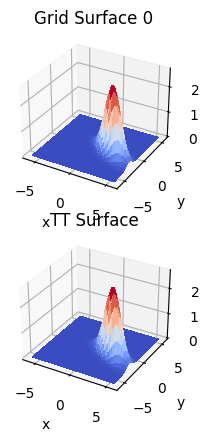

In [ ]:
eps=1.0e-14
rma=6
dim=2
d=5
npt=2**d
xmin=-6.0
xmax=6.0
dx=(xmax-xmin)/npt
x=np.zeros(npt)

gam = np.zeros((dim,dim),dtype=complex)
gam[0][0] = 1 + 1j
gam[0][1] = 1
gam[1][0] = 1
gam[1][1] = 2 - 1j

r = np.zeros(dim)
rj = np.zeros(dim)
pk = np.zeros(dim,dtype=complex)
rj[0]=0.5
rj[1]=0.2
pk[0]=1.0+1j
pk[1]=1j

# Analytical solution GI = \sqrt((2*pi)^n/det(gam))*exp(rk^t gam^{-1} rk/2)
detgam = np.linalg.det(gam)
gami = np.linalg.pinv(gam)
IG=2*np.pi/np.sqrt(detgam)*np.exp(np.dot(pk,np.matmul(gami, pk))*0.5)
print("IG=",IG)
# Numerical solution
# Define grid of coordinates
for i in range(npt):
  x[i] = xmin + i *dx
rx, ry = np.meshgrid(x, x)
# Visualize function generated on a grid
norm2=0.0
G = np.zeros((npt,npt),dtype=complex)
for i in range(npt):
  for j in range(npt):
    r[0] = x[j]
    r[1] = x[i]
    G[i][j] = fun(r)
#   norm2=norm2+G[i][j]*np.conjugate(G[i][j])
    norm2=norm2+G[i][j]
print("Norm G=",norm2*dx*dx)
ax= plt.subplot(2,1,1, projection='3d')
ax.plot_surface(rx, ry, np.abs(G), cmap=cm.coolwarm, antialiased=False)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Grid Surface 0")

# Define tuple of tensor trains txx  for coordinates
ttone=tt.tensor(np.ones(2**d))
xx=tt.tensor(x)

# Quantics
ttone=tt.ones(2, d)
xx=tt.tensor(np.reshape(x, [2]*d))

txx = [gen_1d(xx,ttone,i,dim) for i in range(dim)]
ttoned=tt.kron(ttone,ttone)
# Generate tensor train representation of the function sf
ttVV =tt.multifuncrs2(txx, sff, eps ,verb=0)
ttVV = ttVV.round(eps,rma)
#    print("Norm ttVV",ttVV.norm()**2*dx**dim)
print("Norm ttVVd",tt.dot(ttoned,ttVV)*dx**dim)
# Visualize function generated with tensor train
ax= plt.subplot(2,1,2, projection='3d')
# Evaluate tensor without using full()
dd=[d,d]
VV2 = np.zeros((npt,npt),dtype=complex)
for i in range(np.size(x)):
    for j in range(np.size(x)):
        ind=[i,j]
        VV2[i][j]=ttVV[bi(ind,dd)]

#VV2=np.reshape(ttVV.full(),[npt, npt])
ax.plot_surface(rx, ry, np.abs(VV2), cmap=cm.coolwarm, antialiased=False)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("TT Surface")
plt.show()

##### **3.3. Tensor Inversion**

A simple way of inverting a tensor is by using the cross-approximation, as follows:

In [ ]:
def gen_1d(mat,e,i,d):
    w = mat
    for j in range(i):
        w = tt.kron(w,e)
    for j in range(d-i-1):
        w = tt.kron(e,w)
    return w

In [ ]:
N=2 # number of modes
d=5; ns = 2**d # number of grid points
x=3+2*(np.linspace(0,ns-1,ns)*2/ns-1)  # grid point values
xx=np.reshape(x, [2]*d)  # folded in quantics format
xx = tt.tensor(xx)       # qtt format tensor for each normal coordinate
ttone=tt.ones(2, d)      # one qtt for other coordinates
ttx = [gen_1d(xx,ttone,i,N) for i in range(N)]  # array of normal coordinates

In [ ]:
def finv(f):
  nevals, dim = f.shape
  out = np.zeros((nevals,))
  for ii in range(nevals):
    out[ii] = 1e14
    if f[ii] != 0:
      out[ii] = 1/f[ii]
  return out

In [ ]:
xxinv=tt.multifuncrs([xx], finv, eps= 1e-14,verb=0)

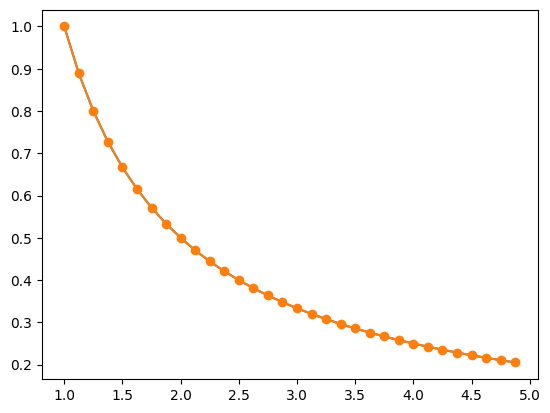

In [ ]:
plt.plot(x,np.reshape(xxinv.full(),ns))
plt.plot(x,1/x,'-o')

#### **4. Minimum of a Function**

tt_min finds (approximate) minimal value of the function on a d-dimensional grid by using a TT-cross-based minimization procedure

In [ ]:
from tt.optimize import tt_min

##### **4.1. Example 1:** Minimize 4-d [Rosenbrock function](https://www.sfu.ca/~ssurjano/rosen.html) on a 4-dimensional grid

In [ ]:
from scipy.optimize import rosen

In [ ]:
def my_rosen(x):
    return rosen(x.T)

In [ ]:
print("Minimize 4-d Rosenbrock function on a 4-dimensional grid (512 points " +
      "along each dimension). The global minimum is 0 in the (1, 1, 1, 1) point.")
val, x_full = tt_min.min_func(my_rosen, -2, 2, d=4, n0=512, rmax=10, nswp=30)

Minimize 4-d Rosenbrock function on a 4-dimensional grid (512 points along each dimension). The global minimum is 0 in the (1, 1, 1, 1) point.
New record: 38.43562519312057 Point: [-1.3111546   1.14677104  1.35812133  1.84344423] fevals: 5120
New record: 38.280576071743596 Point: [-1.3111546   1.14677104  1.28767123  1.6555773 ] fevals: 66560
New record: 2.080595359916628 Point: [0.99021526 1.10763209 1.28767123 1.6555773 ] fevals: 128000
New record: 0.46777206522461456 Point: [1.05283757 1.10763209 1.28767123 1.6555773 ] fevals: 134656
New record: 0.3930489350939108 Point: [1.037182   1.12328767 1.28767123 1.6555773 ] fevals: 233472
New record: 0.32820188732093125 Point: [0.92759295 0.81800391 0.66927593 0.45009785] fevals: 313344
New record: 0.2592860852171525 Point: [1.09197652 1.19373777 1.42074364 2.        ] fevals: 492032
New record: 0.19189119962376444 Point: [1.05283757 1.11545988 1.27201566 1.63209393] fevals: 498688
New record: 0.12923303025853708 Point: [0.9667319  0.935420

##### **4.2. Example 2:** Find minimum of a random 5-dimensional TT tensor

In [ ]:
tens = tt.rand([3, 4, 5, 4, 3], 5, 3)
min_element = min(tens.full().flatten())
print("Minimize random 5-dimensional TT tensor with ranks equal to 3. " +
      "The minimal element is %f" % min_element)
val, point = tt_min.min_tens(tens, rmax=10, nswp=30)

Minimize random 5-dimensional TT tensor with ranks equal to 3. The minimal element is -27.370081
New record: -17.52829159638635 Point: [2 3 1 2 0] elements seen: 30
New record: -27.370081394008608 Point: [1 3 1 2 0] elements seen: 650
New record: -27.370081394008608 Point: [1 3 1 2 0] elements seen: 1712


#### **5 Taylor Series of the Exponential: Scaling and Squaring**

In [32]:
# Taylor series of exp(A) where A is a QTT-matrix
def expA(A,eps=None,rmax=None,N=None):
    global d
    if eps == None:
      eps=1e-14
    if rmax == None:
      rmax= 4
    if N == None:
      N=10
    w0=A*(1.0/2**N)
    e=tt.ones(2,d)   # when A is a TT-tensor
#    e=tt.eye(2,d)   # when A is a TT-matrix
    tm=e
    k=N-1
    while k > 0:
        tm=e+tm*w0*(1.0/k)
        tm=tm.round(eps,rmax)
        k=k-1
    while k < N:
        tm=tm*tm
        tm=tm.round(eps,rmax)
        k=k+1
    return tm

**Example:** Generate the QTT representation of $\text{fun}(x)~=~\text{exp}(-2~x)$

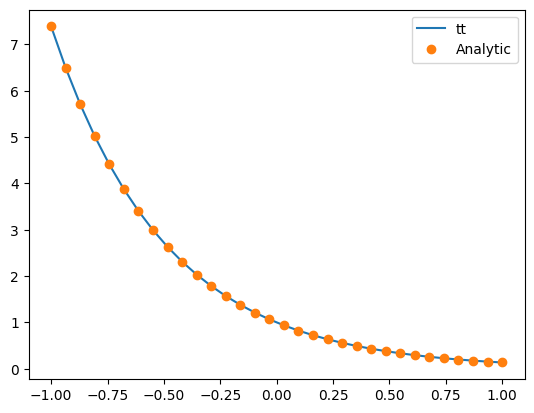

In [33]:
# Example
d=5;x=np.linspace(-1,1,num=2**d)
x=tt.tensor(np.reshape(x,[2]*d))
xn=np.reshape(x.full(),[2**d])

fn=expA(-2*x)
fn=np.reshape(fn.full(),[2**d])
plt.plot(xn,fn,label='tt')
plt.plot(xn,np.exp(-2*xn),'o',label='Analytic')
plt.legend()

#### **6. FFT of Tensor Trains**

Multdimensional FFT of a tensor train can be easily performed by FFT of each core with respect to the physical indices

In [ ]:
def mfft(f,ind):    # non-quantics (warning!)
    # multidimensional fft of function f in (non-quantics) tt format
    # ind=1 for fft, otherwise ifft
    y=tt.tensor.to_list(f)              # makes a list of cores
    d=len(y)
    for k in range(len(y)):             # core index
      for i in range(y[k].shape[0]):
        for j in range(y[k].shape[2]):
          if ind == 1:
            y[k][i,:,j]=np.fft.fft(y[k][i,:,j])*4/len(y[k][i,:,j])
          else:
            y[k][i,:,j] = np.fft.ifft(y[k][i,:,j])*len(y[k][i,:,j])/4
    return tt.tensor.from_list(y)       # builds TT from cores

In [ ]:
def gen_1d(mat,e,i,d):
    w = mat
    for j in range(i):
        w = tt.kron(w,e)
    for j in range(d-i-1):
        w = tt.kron(e,w)
    return w

In [ ]:
def fun(r):
# Generic Gaussian: out = exp(-(r-rj)^t gam (r-rj)/2 + pk^t (r-rj))
    global gam,pk,rj
    out=np.exp(-np.dot((r-rj),np.matmul(gam,(r-rj))*0.5)+np.dot(pk,(r-rj)))
    return out

def sff(r):
    global rj,pk,gam
    nevals, dim = r.shape
    out = np.zeros((nevals,),dtype=complex)
    for ii in range(nevals):
        out[ii]=np.exp(-np.dot((r[ii,:]-rj[:]),np.matmul(gam,(r[ii,:]-rj[:]))*0.5)
                       +np.dot(pk,(r[ii,:]-rj[:])))
    return(out)

Elapsed time: 0.0017919540405273438


Text(0.5, 0.92, 'Grid Surface 0')

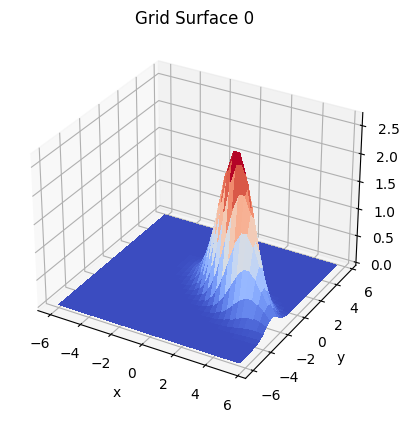

In [ ]:
# FFT using mfft

eps=1e-14
dim=2;d=5;npt=2**d;
xmin=-6;xmax=6;dx=(xmax-xmin)/npt

ttone=tt.tensor(np.ones(2**d),eps=1e-14)
x=np.arange(xmin,xmax,dx)
xx=tt.tensor(x)

rj = np.zeros(dim)
pk = np.zeros(dim,dtype=complex)
rj[0]=0.5
rj[1]=0.2
pk[0]=1.0+1j
pk[1]=1j

gam = np.zeros((dim,dim),dtype=complex)
gam[0][0] = 1 + 1j
gam[0][1] = 1
gam[1][0] = 1
gam[1][1] = 2 - 1j

# Define tuple of tensor trains txx  for coordinates
txx = [gen_1d(xx,ttone,i,dim) for i in range(dim)]
ttoned=tt.kron(ttone,ttone)
# Generate tensor train representation of the function sf
ttVV =tt.multifuncrs2(txx, sff, eps ,verb=0)

t = time.time()
ttVV=mfft(ttVV,1)
print('Elapsed time:',time.time()-t)

# Inverse FFT
back = 1
if back == 1:
  ttVV=mfft(ttVV,-1)
  rx, ry = np.meshgrid(x, x)
  VV2=np.reshape(ttVV.full(),[npt, npt])
else:
  freq = np.fft.fftfreq(x.shape[-1],dx)
  freq = np.fft.fftshift(freq)
  VV2=np.reshape(ttVV.full(),[npt, npt])
  VV2 = np.fft.fftshift(VV2)
  rx, ry = np.meshgrid(freq, freq)

# Plot results
ax= plt.subplot(1,1,1, projection='3d')
ax.plot_surface(rx, ry, np.abs(VV2), cmap=cm.coolwarm, antialiased=False)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Grid Surface 0")

#####Derivatives computed by Fourier Transform

###### Grid implemenation

In [ ]:
def Deri(VV,dx,k):
    # Compute k-th derivative of VV
    npt=len(VV)
    freq = np.fft.fftfreq(npt,dx)
    FTVV = np.fft.fft(VV)
    out =np.fft.ifft(FTVV*(1j*2*np.pi*freq)**k)
    return out

In [ ]:
# Example of k-th derivative of a function by FFT on a 1-d grid

# Define grid
d=7;npt=2**d;L=10;xmin=0;xmax=L;dx=(xmax-xmin)/npt
t=np.arange(xmin,xmax,dx)

# Define function
w1 = 0.8; w2 = 2.2
VV = np.sin(2*np.pi*w1*t)+np.sin(2*np.pi*w2*t)

k=5
# Numerical derivative
VVk=Deri(VV,dx,k)

# Analytical derivative
if (k%2) == 0:
    VVp = (-1)**(k/2)*((2*np.pi*w1)**k*np.sin(2*np.pi*w1*t)+(2*np.pi*w2)**k*np.sin(2*np.pi*w2*t))
else:
    VVp = (-1)**((k-1)/2)*((2*np.pi*w1)**k*np.cos(2*np.pi*w1*t)+(2*np.pi*w2)**k*np.cos(2*np.pi*w2*t))

# Plot results
figure, axis = plt.subplots(3, 1)
plt.subplots_adjust(hspace=1.5)

# Time domain representation for sine wave 1
axis[0].set_title('Sinusoidal wave with freqs w1=0.8 and w2=2.2 Hz')
axis[0].plot(t, VV)
axis[0].set_xlabel('Time')
axis[0].set_ylabel('Amplitude')
axis[0].grid()

# Time domain representation for sine wave 1
axis[1].set_title('k-th Derivative of Sinusoidal wave')
axis[1].plot(t, VVk)
axis[1].plot(t, VVp,'+')
axis[1].set_xlabel('Time')
axis[1].set_ylabel('Amplitude')
axis[1].grid()

# Frequency domain representation
FTVV = np.fft.fft(VV)*4/npt
freq = np.fft.fftfreq(npt,dx)
FTVV = FTVV[range(int(npt/2))]
freq = freq[range(int(npt/2))]
axis[2].set_title('Fourier transform depicting the frequency components')
axis[2].plot(freq, abs(FTVV))
axis[2].set_xlabel('Frequency')
axis[2].set_ylabel('Amplitude')
axis[2].grid()

plt.show()

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


###### TT Implementation

In [ ]:
def sf2(r):
    global rj,pk,gam
    w1 = 0.8; w2 = 2.2
    nevals, dim = r.shape
    out = np.zeros((nevals,),dtype=complex)
    for ii in range(nevals):
        #out[ii]=np.exp(1j*2*np.pi*w1*r[ii,:]-r[ii,:]*r[ii,:])
        out[ii]=np.sin(2*np.pi*w1*r[ii,:])+np.sin(2*np.pi*w2*r[ii,:])
    return(out)

In [ ]:
def ttDeri(f,dx,kk):  # non-quantics
    # kk-th gradient of f
    y=tt.tensor.to_list(f)              # makes a list of cores
    yc=np.empty_like(y, dtype=complex)
    pp=np.fft.fftfreq(len(y[0][0,:,0]),dx)
    for k in range(len(y)):             # core index
      for i in range(y[k].shape[0]):
        for j in range(y[k].shape[2]):
            yc[k][i,:,j]=np.fft.fft(y[k][i,:,j])*4/len(y[0][0,:,0])
            for l in range(kk):
                yc[k][i,:,j]=1j*2*np.pi*np.transpose(pp)*yc[k][i,:,j]
    out=tt.tensor.from_list(yc)       # builds TT from cores
    return mfft(out,-1)

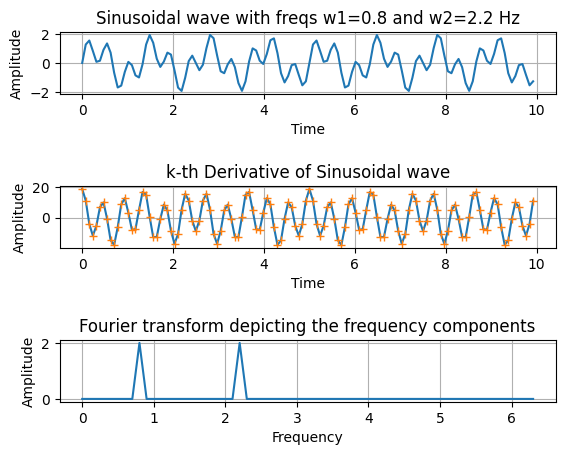

In [ ]:
eps=1e-14
dim=1;d=7;npt=2**d
L=10;
xmin=0
xmax=L
dx=(xmax-xmin)/npt
t=np.arange(xmin,xmax,dx)

xx=tt.tensor(t)
p = np.fft.fftfreq(npt,dx)

# Generate tensor train representation of sf
ttVV =tt.multifuncrs2([xx], sf2, eps ,verb=0)
VV=ttVV.full().reshape(npt)

k=1
# Numerical k-th gradient of ttVV
VVk=ttDeri(ttVV,dx,k)
VVk=VVk.full().reshape(npt)

# Analytical k-th gradient
w1 = 0.8; w2 = 2.2
if (k%2) == 0:
    VVp = (-1)**(k/2)*((2*np.pi*w1)**k*np.sin(2*np.pi*w1*t)+(2*np.pi*w2)**k*np.sin(2*np.pi*w2*t))
else:
    VVp = (-1)**((k-1)/2)*((2*np.pi*w1)**k*np.cos(2*np.pi*w1*t)+(2*np.pi*w2)**k*np.cos(2*np.pi*w2*t))

# Plot results
figure, axis = plt.subplots(3, 1)
plt.subplots_adjust(hspace=1.5)

# Time domain representation for sine wave 1
axis[0].set_title('Sinusoidal wave with freqs w1=0.8 and w2=2.2 Hz')
axis[0].plot(t, VV)
axis[0].set_xlabel('Time')
axis[0].set_ylabel('Amplitude')
axis[0].grid()

# Time domain representation for sine wave 1
axis[1].set_title('k-th Derivative of Sinusoidal wave')
axis[1].plot(t, VVk)
axis[1].plot(t, VVp,'+')
axis[1].set_xlabel('Time')
axis[1].set_ylabel('Amplitude')
axis[1].grid()

# Frequency domain representation
#FTVV = np.fft.fft(VV)*4/npt
FTVV = mfft(ttVV,1)
FTVV = FTVV.full().reshape(npt)

freq = np.fft.fftfreq(npt,dx)
FTVV = FTVV[range(int(npt/2))]
freq = freq[range(int(npt/2))]
axis[2].set_title('Fourier transform depicting the frequency components')
axis[2].plot(freq, abs(FTVV))
axis[2].set_xlabel('Frequency')
axis[2].set_ylabel('Amplitude')
axis[2].grid()

plt.show()